## TODO:
- add noise to label to add diversity

In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import models
import utils
import os
import glob
import visualize

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray' 
%load_ext autoreload
%autoreload 2

c:\users\fanhangming\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def pre_process(img):
    return img * 2 - 1

def sample_noise(batch_size, dim):
    return np.random.uniform(-1, 1, size=(batch_size, dim))

def add_label_noise(inputs):
    return inputs

# Build specific format t to show out
formal_t = np.zeros((100, 10))
for i in range(10):
    formal_t[i*10:i*10+10, i] += 1

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./dataset/MNIST_data', one_hot=True)

batch_size = 64

Extracting ./dataset/MNIST_data\train-images-idx3-ubyte.gz
Extracting ./dataset/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./dataset/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./dataset/MNIST_data\t10k-labels-idx1-ubyte.gz


In [46]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=2000, print_every=100, batch_size=128, num_epoch=10, n_critic=5):
    
    D_losses = []
    G_losses = []
    max_iter = mnist.train.num_examples*num_epoch // (batch_size * n_critic)
    for it in range(max_iter):
        if (it + 1) % show_every == 0:
            noise_z = sample_noise(100, noise_dim)
            samples = sess.run(G_sample, feed_dict={z:noise_z, t: add_label_noise(formal_t)})
            fig = visualize.show_images(samples)
            plt.show()
            plt.plot(range(len(D_losses)), D_losses)
            plt.title('D_loss')
            plt.show()
            D_losses.clear()
            plt.plot(range(len(G_losses)), G_losses)
            plt.title('G_loss')
            plt.show()
            G_losses.clear
        
        for i in range(n_critic):
            noise_z = sample_noise(batch_size, noise_dim)
            minibatch, mini_t = mnist.train.next_batch(batch_size)
            minibatch = np.reshape(minibatch, [-1, 28, 28, 1])
            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: pre_process(minibatch), z: noise_z, t: add_label_noise(mini_t)})
            D_losses.append(D_loss_curr)
            
        noise_z = sample_noise(batch_size, noise_dim)   
        _, G_loss_curr = sess.run([G_train_step, G_loss,], feed_dict={z:noise_z, t: mini_t})
        G_losses.append(G_loss_curr)
        
        if it % print_every == 0:
            print('Iter: {0}/{1}, D: {2:.4}, G: {3:.4}'.format(it, max_iter, D_loss_curr, G_loss_curr))
    print('Final images')
    noise_z = sample_noise(100, noise_dim)
    samples = sess.run(G_sample, feed_dict={z:noise_z, t: add_label_noise(formal_t)})
    
    fig = visualize.show_images(samples, final="./images/SAGAN_28_28")
    plt.show()

In [43]:
tf.reset_default_graph()

noise_dim = 100

x = tf.placeholder(tf.float32, [None, 28, 28, 1])
z = tf.placeholder(tf.float32, [None, noise_dim])
t = tf.placeholder(tf.float32, [None, 10])

generator = models.generator_SA_GAN
discriminator = models.discriminator_SA_GAN
classifier = models.classifier_SA_GAN

G_sample = generator(z, t, reuse=False)
logits_real, feature_real = discriminator(x, reuse=False)
logits_fake, feature_fake = discriminator(G_sample, reuse=True)
class_real = classifier(feature_real, reuse=False)
class_fake = classifier(feature_fake, reuse=True)

C_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'classifier')
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator') + C_vars
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') + C_vars

In [44]:
def wgangp_loss(logits_real, class_real, logits_fake, class_fake, batch_size, x, G_sample):
    # TODO: compute D_loss and G_loss
    D_loss = tf.reduce_mean(logits_fake) - tf.reduce_mean(logits_real)
    G_loss = -tf.reduce_mean(logits_fake)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    shape = tf.concat((tf.shape(x)[0:1], tf.tile([1], [x.shape.ndims - 1])), axis=0)
    eps = tf.random_uniform(shape=shape, minval=0., maxval=1.)
    x_hat = x + eps * (G_sample - x)
    
    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        pred = discriminator(x_hat)
        grad_D_x_hat = tf.gradients(pred, x)[0]
        
    #grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grad_D_x_hat), reduction_indices=1))
    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grad_D_x_hat), reduction_indices=tf.range(1, x.shape.ndims)))
    grad_pen = lam * tf.reduce_mean((grad_norm - 1.) ** 2)
    
    C_loss_real = tf.reduce_mean(tf.losses.softmax_cross_entropy(t, logits=class_real))
    C_loss_fake = tf.reduce_mean(tf.losses.softmax_cross_entropy(t, logits=class_fake))
    D_loss = D_loss + grad_pen + C_loss_real + C_loss_fake
    G_loss += C_loss_fake
    
    return D_loss, G_loss

D_loss, G_loss  =wgangp_loss(logits_real, class_real, logits_fake, class_fake, batch_size, x, G_sample)
D_train_step = tf.train.AdamOptimizer(learning_rate=4e-3, beta1=0.5).minimize(D_loss, var_list=D_vars)
G_train_step = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5).minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

Iter: 0/8593, D: 1.221e+03, G: 0.6569
Iter: 50/8593, D: 4.748, G: 1.111
Iter: 100/8593, D: 4.265, G: -0.1452
Iter: 150/8593, D: 3.724, G: -0.805
Iter: 200/8593, D: 2.468, G: -2.241


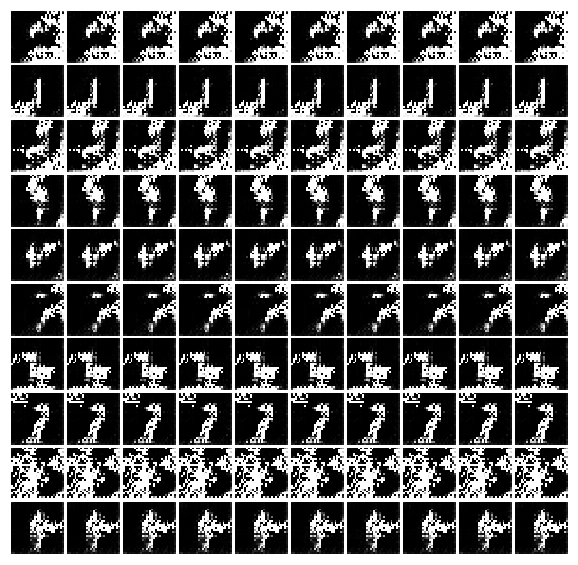

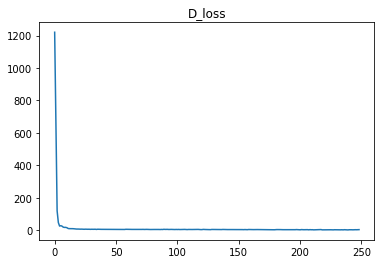

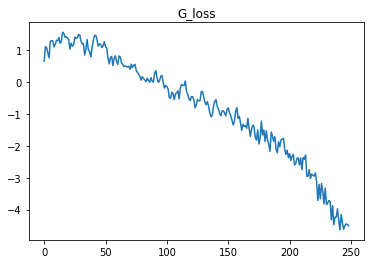

Iter: 250/8593, D: 2.449, G: -4.807
Iter: 300/8593, D: 2.95, G: -6.662
Iter: 350/8593, D: 3.087, G: -7.221
Iter: 400/8593, D: 5.165, G: 0.4011
Iter: 450/8593, D: 2.694, G: -0.2634


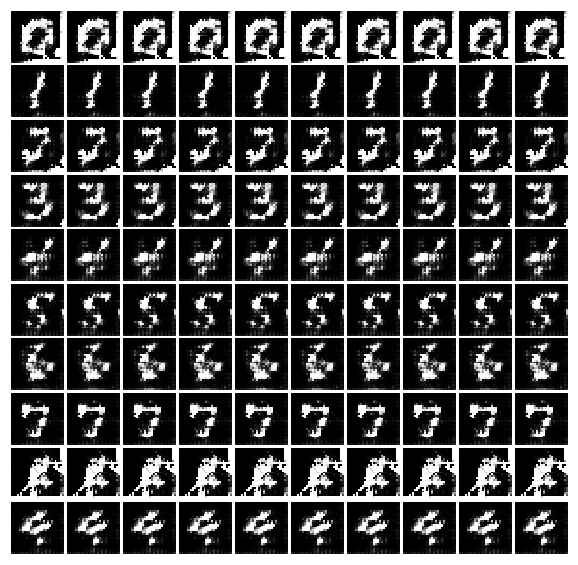

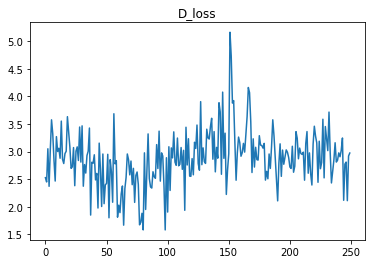

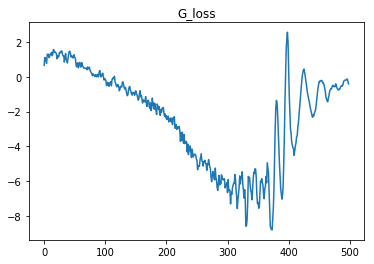

Iter: 500/8593, D: 3.094, G: -0.8269
Iter: 550/8593, D: 2.435, G: -1.578
Iter: 600/8593, D: 56.35, G: 2.633
Iter: 650/8593, D: 6.267, G: 2.165
Iter: 700/8593, D: 5.583, G: 1.468


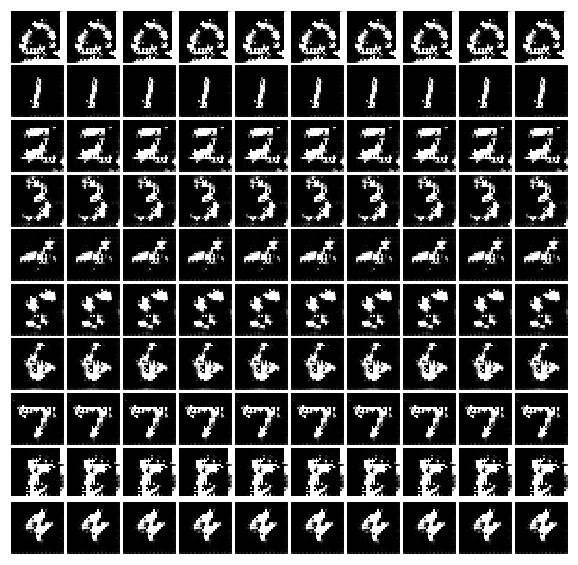

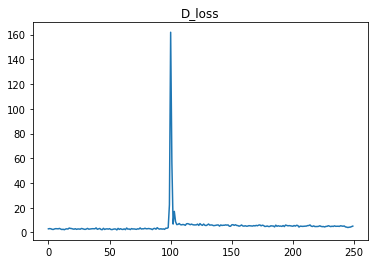

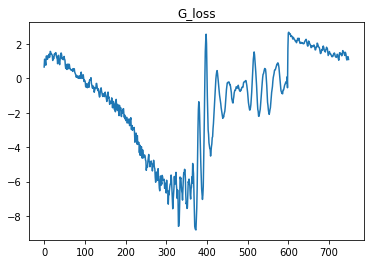

Iter: 750/8593, D: 5.142, G: 1.189
Iter: 800/8593, D: 3.849, G: 0.8392
Iter: 850/8593, D: 4.696, G: 1.126
Iter: 900/8593, D: 3.596, G: 1.594
Iter: 950/8593, D: 3.156, G: 0.6695


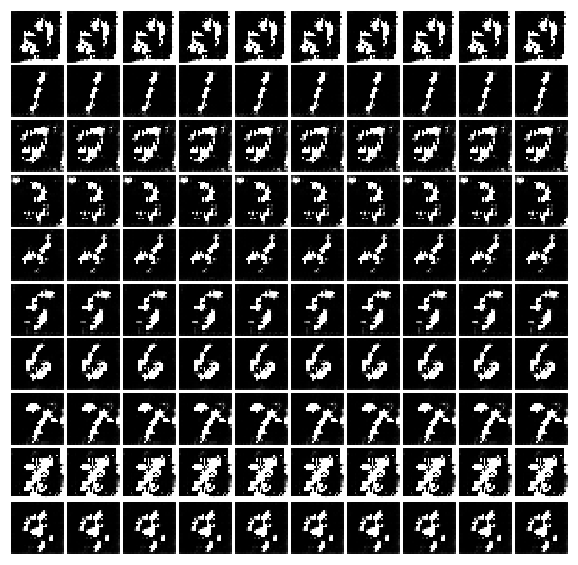

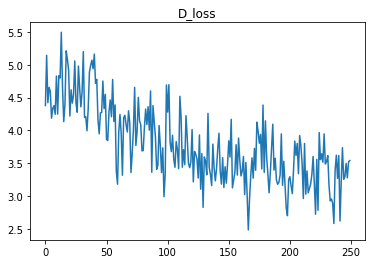

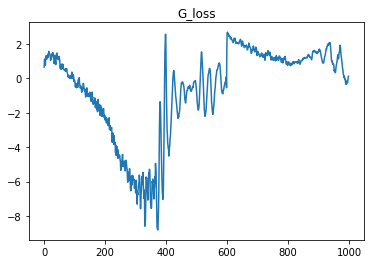

Iter: 1000/8593, D: 3.174, G: 0.2685
Iter: 1050/8593, D: 3.081, G: -0.1018
Iter: 1100/8593, D: 2.818, G: -0.3442
Iter: 1150/8593, D: 3.551, G: 0.1146
Iter: 1200/8593, D: 3.668, G: 1.415


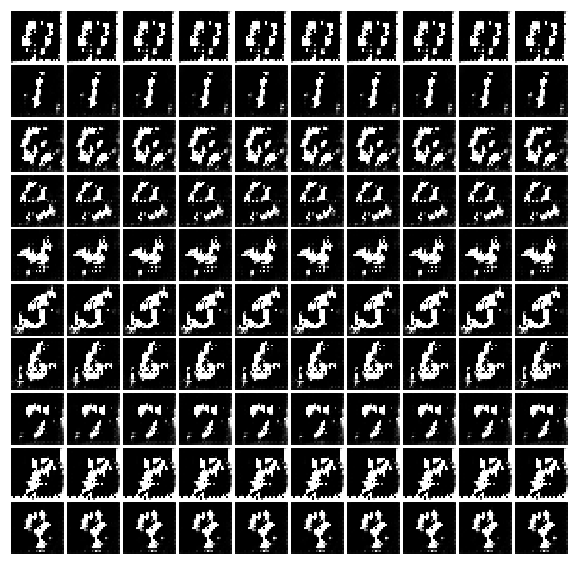

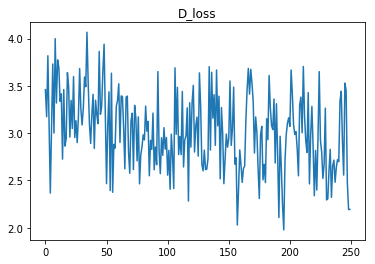

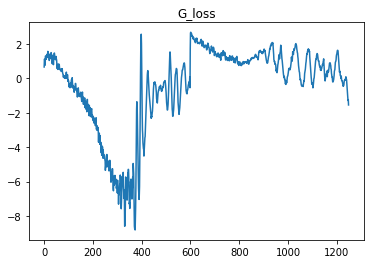

Iter: 1250/8593, D: 3.189, G: -1.723
Iter: 1300/8593, D: 2.976, G: -0.2331
Iter: 1350/8593, D: 3.148, G: -2.083
Iter: 1400/8593, D: 2.163, G: -0.3111
Iter: 1450/8593, D: 2.707, G: 0.1871


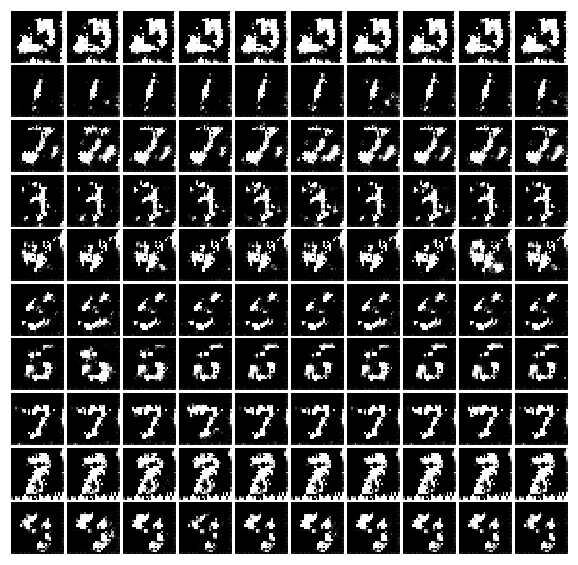

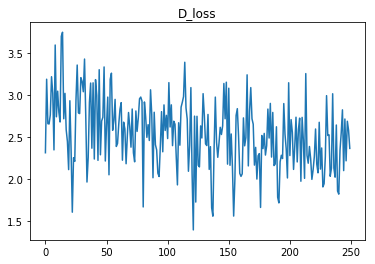

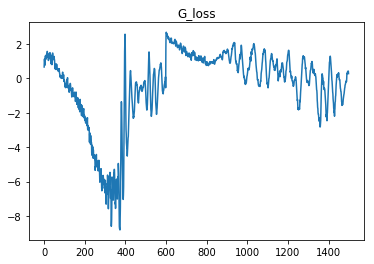

Iter: 1500/8593, D: 2.663, G: 0.226
Iter: 1550/8593, D: 2.081, G: -0.2244
Iter: 1600/8593, D: 1.991, G: 0.3699
Iter: 1650/8593, D: 2.807, G: -0.07115
Iter: 1700/8593, D: 3.531, G: 0.4601


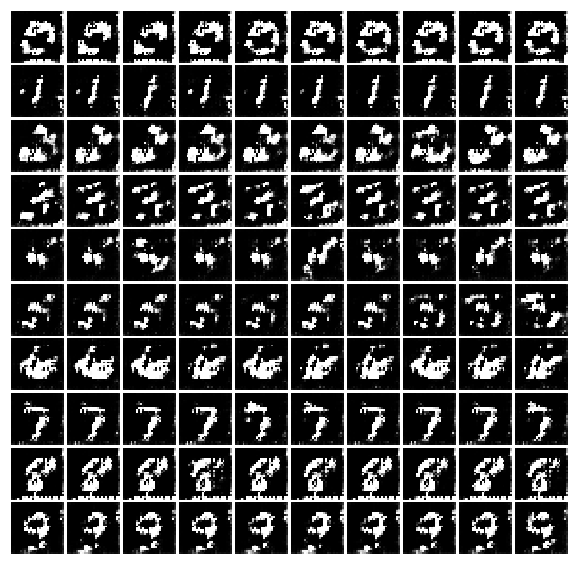

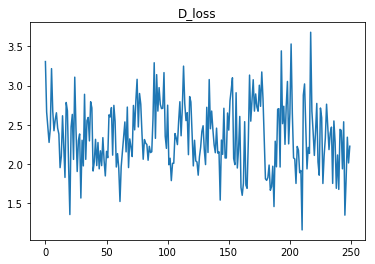

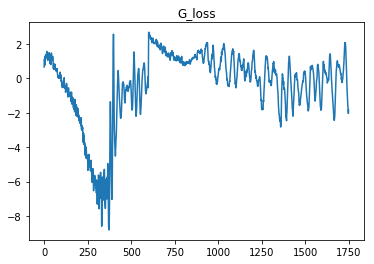

Iter: 1750/8593, D: 2.615, G: -1.676
Iter: 1800/8593, D: 2.058, G: 1.615
Iter: 1850/8593, D: 2.757, G: 0.3769
Iter: 1900/8593, D: 2.439, G: -0.1456
Iter: 1950/8593, D: 2.555, G: 0.1621


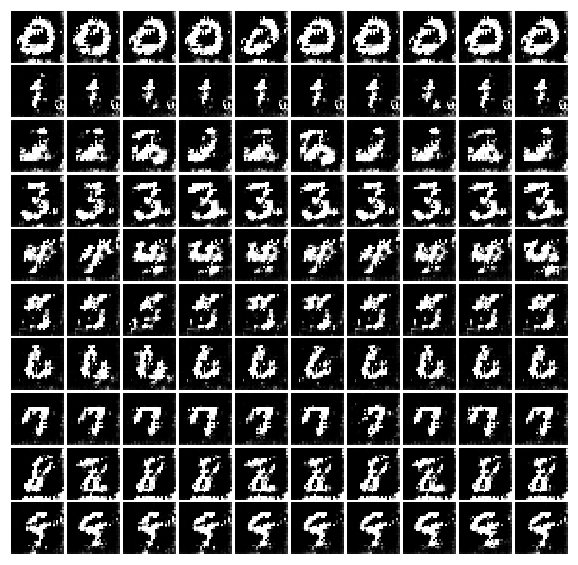

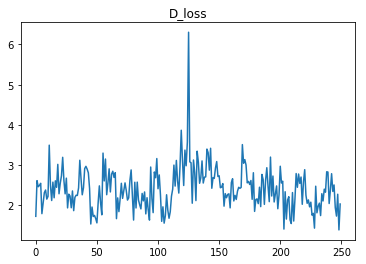

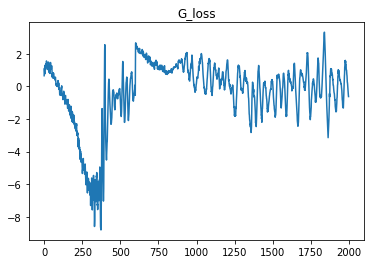

Iter: 2000/8593, D: 2.241, G: -0.7983
Iter: 2050/8593, D: 2.913, G: -0.7932
Iter: 2100/8593, D: 2.669, G: -0.2897
Iter: 2150/8593, D: 2.105, G: -1.241
Iter: 2200/8593, D: 2.152, G: 0.2017


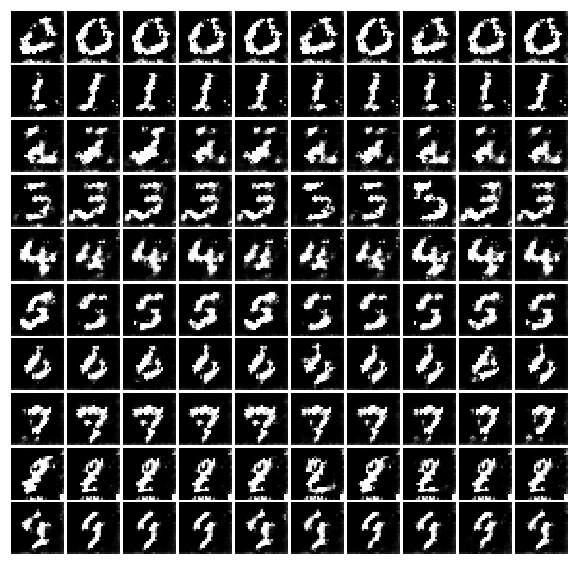

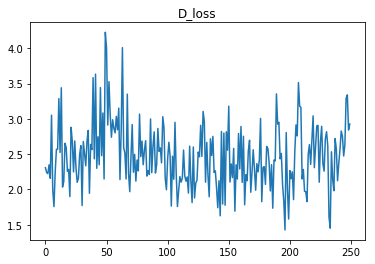

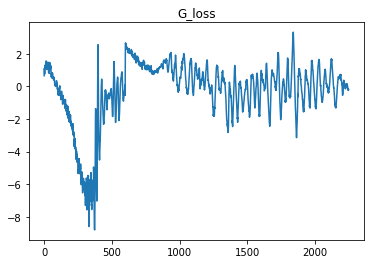

Iter: 2250/8593, D: 2.091, G: -0.1637
Iter: 2300/8593, D: 2.049, G: -1.247
Iter: 2350/8593, D: 3.598, G: -1.718
Iter: 2400/8593, D: 2.549, G: -0.4622
Iter: 2450/8593, D: 2.175, G: -0.3157


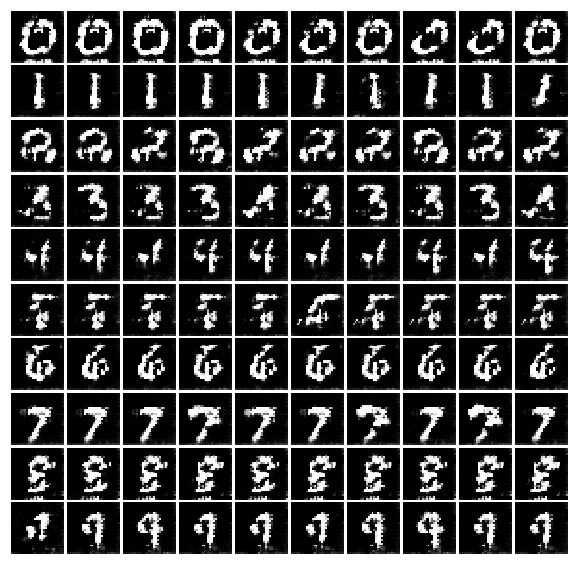

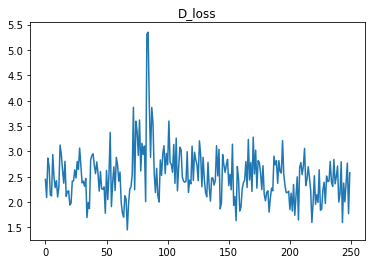

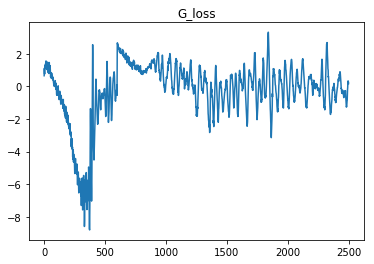

Iter: 2500/8593, D: 2.188, G: 0.09892
Iter: 2550/8593, D: 3.28, G: 0.4139
Iter: 2600/8593, D: 2.715, G: -0.08827
Iter: 2650/8593, D: 2.267, G: 0.4476
Iter: 2700/8593, D: 2.667, G: -1.13


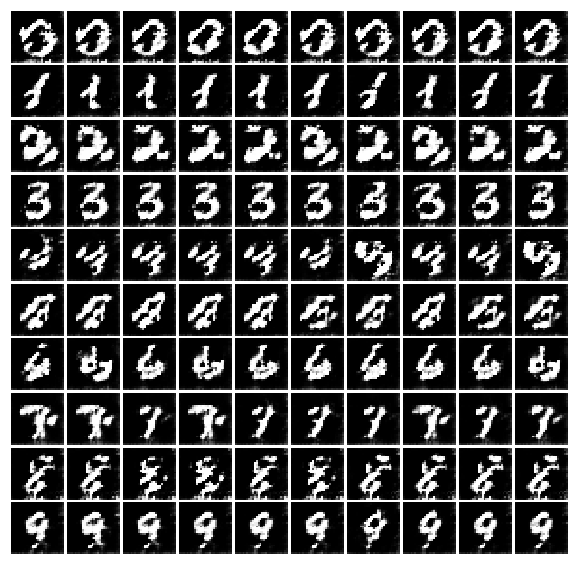

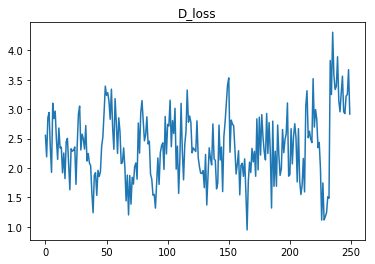

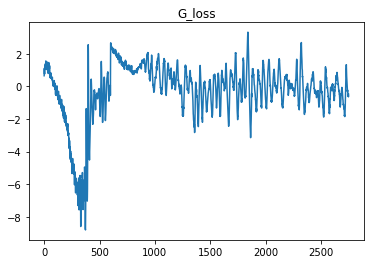

Iter: 2750/8593, D: 2.424, G: -0.6289
Iter: 2800/8593, D: 3.045, G: 0.04836


KeyboardInterrupt: 

In [48]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step, 
              show_every = 250, print_every=50, batch_size=batch_size, num_epoch=10, n_critic=1)